- **Controllo se la GPU di Recas è disponibile**

In [1]:
import tensorflow as tf

# Configure GPU options
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-05-15 09:49:22.672495: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


2024-05-15 09:49:24.875909: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 09:49:25.070522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2970 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:01:00.0, compute capability: 8.0


- **La Gpu Recas ha una NVIDIA A100 2970MB memoria; ne limito l'utilizzo di memoria**

In [2]:
import tensorflow as tf

# Limit memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(
            gpu,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2970)])

2024-05-20 15:33:14.532765: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
import sys
sys.path.append('/usr/local/lib/python3.8/dist-packages/torch/__init__.py')
sys.path.append('/lustrehome/emanueleamato/.local/lib/python3.11/site-packages')
import splitfolders
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten,Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import LSTM, Reshape, RepeatVector
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math





In [ ]:
'''
    # Define input and output directories
    input_folder = '/lustrehome/emanueleamato/ViT_Test/Train/'  # Path to the folder containing images to split
    output_folder = '/lustrehome/emanueleamato/ViT_Test/Validation/'  # Path to the folder where split images will be saved

    # Split data into train and validation sets with a ratio of 80:20
    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.78, .22))
    
'''

In [30]:
n_classes = 2
imgWidth = 64
imgHeight = 64
numberOfEpochs = 50
batchSize = 32
learning_rate = 0.0001
momentum = 0.95
decay_rate = 0.1

optimizer = Adam(lr=learning_rate, beta_1=momentum, decay=decay_rate)

In [31]:
#Data Augumentation -> reduce overfitting when training a machine learning model,by training models on several slightly-modified copies of existing data.
TrainingDirectory= "/lustrehome/emanueleamato/ViT_Test/Train"
train_Datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05)
                                   #zoom_range=0.4,
                                   #horizontal_flip= True,
                                   #shear_range=0.4)

train_generator = train_Datagen.flow_from_directory(TrainingDirectory,
                                                    batch_size=batchSize,
                                                    class_mode= 'categorical',
                                                    target_size=(imgWidth,imgHeight))


Found 13501 images belonging to 2 classes.


In [32]:
ValidationDirectory= "/lustrehome/emanueleamato/ViT_Test/Validation"

#Validation Dataset should not be modified 
validation_Datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = train_Datagen.flow_from_directory(ValidationDirectory,
                                                    batch_size=batchSize,
                                                    class_mode= 'categorical',
                                                    target_size=(imgWidth,imgHeight))


Found 3807 images belonging to 2 classes.


In [33]:

def SimpleCNN():
    model = Sequential()
    
    # Passo 1: Convoluzione -> Attivazione -> Dropout
    model.add(Conv2D(8, (3, 3), strides=(1, 1), padding='same', input_shape=(64, 64, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    # Passo 2: Convoluzione -> Attivazione -> Pooling
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Passo 3: Convoluzione -> Pooling
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Appiattimento (flatten)
    model.add(Flatten())
    
    # Passo 4: Fully Connected Layer -> Attivazione
    model.add(Dense(32))
    model.add(Activation('relu'))
    
    # Passo 5: Fully Connected Layer (output layer)
    model.add(Dense(2))  # Numero di classi
    model.add(Activation('softmax'))  # Softmax per output di classificazione
    
    return model


In [34]:

# Definisci il modello
model = SimpleCNN()


model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 8)         224       
                                                                 
 activation_8 (Activation)   (None, 64, 64, 8)         0         
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 8)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 activation_9 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                      

In [36]:
# early stopping 

callback = EarlyStopping(monitor='val_loss', patience =5, verbose =1, mode = 'auto')

#if we find a better moder we will save it here: 

bestModelFileName=  "/lustrehome/emanueleamato/ViT_Test/SimpleCNN_model.h5"
bestModel= ModelCheckpoint(bestModelFileName,monitor='val_accuracy', verbose=1,save_best_only=True)


- **<u>Prima di addestrare il modello tieni bene in chiaro che si creano file nascosti da dover trattare ( Vanno Eliminati )</u>**
- Fallo da terminale
  


It’s necessary to freeze the convolution base of the conv base in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only possible to fine-tune the top layers of the convolutional base **once the classifier on top has already been trained**. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed

Below, first train with no limit to lr - with conv_base frozen - only my top layers

Then, unfreeze last model conv block , recompile and train all with LOW lr=1e-5

In [37]:
# Train the model
history=model.fit(
    train_generator,
    epochs=numberOfEpochs,
    verbose=1,
    validation_data=validation_generator,
    callbacks = [bestModel])


Epoch 1/50


2024-05-20 15:37:28.919903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


422/422 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.8049
Epoch 2: val_accuracy improved from 0.78566 to 0.79958, saving model to /lustrehome/emanueleamato/ViT_Test/SimpleCNN_model.h5
422/422 [==============================] - 189s 449ms/step - loss: 0.5151 - accuracy: 0.8049 - val_loss: 0.5558 - val_accuracy: 0.7996
Epoch 3/50
422/422 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.8125
Epoch 3: val_accuracy improved from 0.79958 to 0.81508, saving model to /lustrehome/emanueleamato/ViT_Test/SimpleCNN_model.h5
422/422 [==============================] - 167s 396ms/step - loss: 0.4958 - accuracy: 0.8125 - val_loss: 0.5409 - val_accuracy: 0.8151
Epoch 4/50
422/422 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.8206
Epoch 4: val_accuracy did not improve from 0.81508
422/422 [==============================] - 184s 436ms/step - loss: 0.4837 - accuracy: 0.8206 - val_loss: 0.5346 - val_accuracy: 0.8117
Epoch 5/50
422/

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



422/422 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8284
Epoch 12: val_accuracy improved from 0.82164 to 0.82375, saving model to /lustrehome/emanueleamato/ViT_Test/SimpleCNN_model.h5
422/422 [==============================] - 179s 424ms/step - loss: 0.4449 - accuracy: 0.8284 - val_loss: 0.4993 - val_accuracy: 0.8237
Epoch 13/50
422/422 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.8276
Epoch 13: val_accuracy did not improve from 0.82375
422/422 [==============================] - 189s 449ms/step - loss: 0.4452 - accuracy: 0.8276 - val_loss: 0.4992 - val_accuracy: 0.8185
Epoch 14/50
422/422 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8290
Epoch 14: val_accuracy did not improve from 0.82375
422/422 [==============================] - 271s 642ms/step - loss: 0.4432 - accuracy: 0.8290 - val_loss: 0.5035 - val_accuracy: 0.8127
Epoch 15/50
422/422 [==============================] - ETA: 0s - loss: 0.4423 - accur

In [ ]:
# Save the trained model
model.save('fine_tuned_resnet50_LSTM_model.h5')

- **Accuracy**
- **Plots**

In [38]:
#display the result using pyplot
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss'] 
epochs=range(len(acc)) #for the max value in the diagram

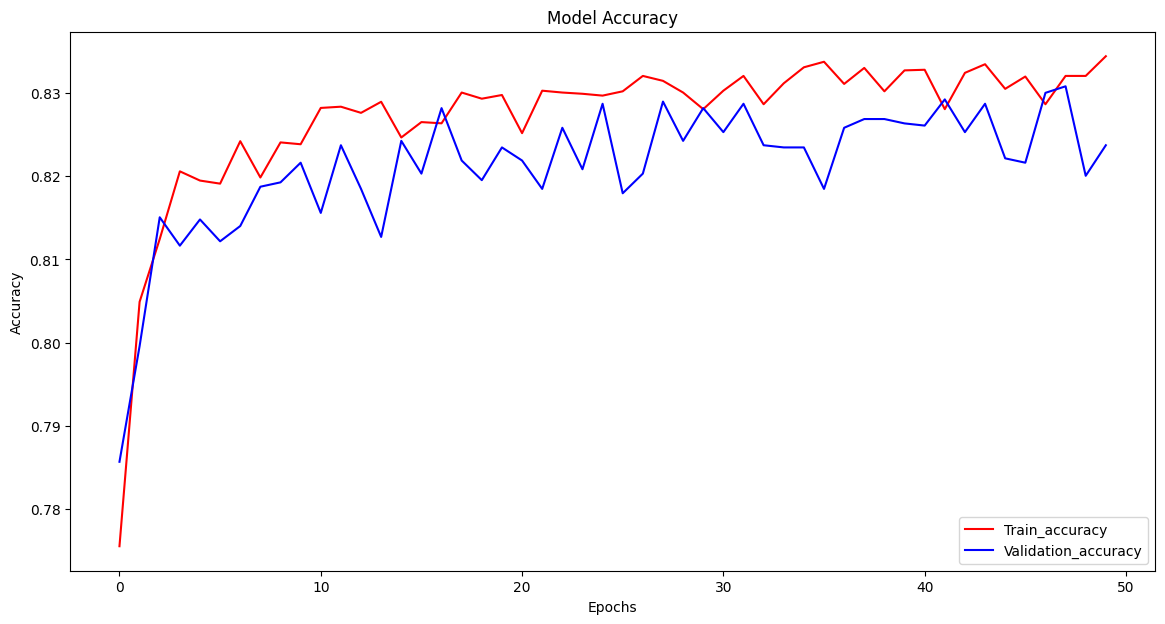

In [39]:
#accuracy chart 
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r', label="Train_accuracy")
plt.plot(epochs,val_acc,'b', label="Validation_accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.show()